## Black-Litterman Model Summary

### Methodology

1. **Reverse Optimization**: Derived implied equilibrium returns (π) from market cap weights using the formula `π = λΣw`
   - Calculated risk aversion coefficient (λ) from market portfolio characteristics
   - These represent what the market "believes" about future returns

2. **Investor Views**: Defined subjective views about future performance
   - View 1: US Large Cap Growth outperforms Value by 3%
   - View 2: Emerging Markets absolute return of 8%
   - View 3: US Growth outperforms International by 4%

3. **Black-Litterman Blending**: Combined equilibrium returns with investor views
   - Views weighted by confidence levels
   - Higher confidence = greater influence on final returns
   - τ parameter controls uncertainty in prior beliefs

4. **Portfolio Optimization**: Used BL expected returns to find optimal allocation
   - Maximized Sharpe ratio subject to long-only constraints
   - Compared to market cap weighted portfolio

### Key Parameters
- **Risk-free rate**: 4%
- **τ (prior uncertainty)**: 0.025
- **λ (risk aversion)**: Derived from market portfolio
- **Historical data**: 5 years of daily returns

### Interpretation
The resulting optimal weights reflect a balance between:
- Market equilibrium (what everyone collectively believes)
- Your subjective views (what you think will happen)
- Statistical uncertainty (confidence in predictions)

Adjust the views, confidence levels, and τ parameter to reflect your market outlook.


In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
import requests
import pandas as pd
import json
import talib
import numpy as np
import time

import yfinance as yf
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')


SECRET_FP = "./secrets.json"
with open(SECRET_FP, 'r') as file:
    secrets = json.load(file)
API_KEY = secrets['eodhd_api_key']

sys.path.append(r"C:\Users\msands\OneDrive\Documents\code\submodule")
from eodhd import  Chain, ChainHistory, Security, Index
import plot
from plot import ChartStyle
cs = ChartStyle(figsize=(20,8),nyears=1, date_fmt="%Y-%m", grid=False)


# Market Implied Equilibrium Weights

In [ ]:
# Free float adjusted market cap estimates; Bottom Up Index Aggregate Market Cap
free_float_adj_mkt_cap = {
    # 'SP500': 40_000_000_000_000,      # S&P 500
    # "R1K": 43_000_000_000_000,        # Russell 1000
    "R1KG": 21_500_000_000_000,       # Russell 1000 Growth
    "R1KV": 21_500_000_000_000,       # Russell 1000 Value
    "R2K": 2_200_000_000_000,         # Russell 2000
    # "R2KG": 1_100_000_000_000,        # Russell 2000 Growth
    # "R2KV": 1_100_000_000_000,        # Russell 2000 Value
    # "RMC": 6_500_000_000_000,         # Russell Mid Cap
    "RMCG": 3_250_000_000_000,        # Russell Mid Cap Growth
    "RMCV": 3_250_000_000_000,        # Russell Mid Cap Value
    "INT": 25_000_000_000_000,        # International Developed Markets (MSCI EAFE)
    "EM": 6_000_000_000_000,          # Emerging Markets (MSCI EM)
}

# MSCI ACWI (All Country World Index) country weights are determined by free float-adjusted market capitalization.
msci_acwi_us_alloc = 0.64


In [ ]:
us_indices = {k: v for k, v in free_float_adj_mkt_cap.items() if k not in ['INT', 'EM']}
intl_indices = {k: v for k, v in free_float_adj_mkt_cap.items() if k in ['INT', 'EM']}

total_us_mkt_cap = sum(us_indices.values())
total_intl_mkt_cap = sum(intl_indices.values())

weights = {}

# US indices: scale to msci_acwi_us_alloc
for ticker, mkt_cap in us_indices.items():
    weights[ticker] = (mkt_cap / total_us_mkt_cap) * msci_acwi_us_alloc * 100

# International & EM indices: scale to remaining allocation
intl_alloc = 1 - msci_acwi_us_alloc
for ticker, mkt_cap in intl_indices.items():
    weights[ticker] = (mkt_cap / total_intl_mkt_cap) * intl_alloc * 100

df_weights = pd.DataFrame({
    'Ticker': list(weights.keys()),
    'Market Cap': [free_float_adj_mkt_cap[t] for t in weights.keys()],
    'Weight (%)': list(weights.values())
})

df_weights # market inferred equilibrium weights

,Ticker,Market Cap,Weight (%)
0,R1KG,21500000000000,26.615087
1,R1KV,21500000000000,26.615087
2,R2K,2200000000000,2.723404
3,RMCG,3250000000000,4.023211
4,RMCV,3250000000000,4.023211
5,INT,25000000000000,29.032258
6,EM,6000000000000,6.967742


# Historical Returns and Volatility

In [ ]:
etf_map = {
    "R1KG": "IWF",  # Russell 1000 Growth Index
    "R1KV": "IWD",  # Russell 1000 Value Index
    "R2K": "IWM",   # Russell 2000 Index
    "RMCG": "IWP",  # Russell Midcap Growth Index
    "RMCV": "IWS",  # Russell Midcap Value Index
    "INT": "EFA",   # MSCI EAFE Index (International Developed)
    "EM": "EEM",    # MSCI Emerging Markets Index
}

sec = Security(ticker=list(etf_map.values()), start='2000-01-01')

# Create reverse mapping (ETF ticker -> Index name)
reverse_map = {v: k for k, v in etf_map.items()}

prices = sec.prices.rename(columns=reverse_map)
returns = sec.returns.rename(columns=reverse_map)

returns.index = pd.to_datetime(returns.index)

In [ ]:
def get_first_valid_dates(df):
    first_dates = {}
    for col in df.columns:
        first_valid_idx = df[col].first_valid_index()
        first_dates[col] = first_valid_idx
    
    result_df = pd.DataFrame({
        'Column': list(first_dates.keys()),
        'First Valid Date': list(first_dates.values())
    })
    return result_df

get_first_valid_dates(returns)

,Column,First Valid Date
0,EM,2003-04-14
1,INT,2003-04-14
2,R1KV,2003-04-14
3,R1KG,2003-04-14
4,R2K,2003-04-14
5,RMCG,2003-04-14
6,RMCV,2003-04-14


## Returns

In [ ]:
# Calculate comprehensive return statistics
stats_list = []

for col in returns.columns:
    col_returns = returns[col].dropna()
    
    # Calculate number of years
    n_years = len(col_returns) / 252
    
    # Total compound return
    total_compound_return = (1 + col_returns).prod() - 1
    
    # Annualized total return (CAGR)
    annualized_return = (1 + total_compound_return) ** (1 / n_years) - 1
    
    # Average annual return (arithmetic mean)
    avg_annual_return = col_returns.mean() * 252
    
    annual_returns_by_year = []
    years = col_returns.index.year.unique()
    
    for year in years:
        year_returns = col_returns[col_returns.index.year == year]
        annual_ret = (1 + year_returns).prod() - 1
        annual_returns_by_year.append(annual_ret)
    
    annual_returns_series = pd.Series(annual_returns_by_year)
    
    stats_list.append({
        'Ticker': col,
        'Total Compound Return (%)': total_compound_return * 100,
        'Annualized Return (CAGR) (%)': annualized_return * 100,
        'Average Annual Return (%)': avg_annual_return * 100,
        'Min Annual Return (%)': annual_returns_series.min() * 100,
        '25th Percentile Annual Return (%)': annual_returns_series.quantile(0.25) * 100,
        'Median Annual Return (%)': annual_returns_series.median() * 100,
        '75th Percentile Annual Return (%)': annual_returns_series.quantile(0.75) * 100,
        'Max Annual Return (%)': annual_returns_series.max() * 100,
        'Years of Data': n_years
    })

df_return_stats = pd.DataFrame(stats_list)
df_return_stats = df_return_stats.round(2)

df_return_stats


,Ticker,Total Compound Return (%),Annualized Return (CAGR) (%),Average Annual Return (%),Min Annual Return (%),25th Percentile Annual Return (%),Median Annual Return (%),75th Percentile Annual Return (%),Max Annual Return (%),Years of Data
0,EM,215.80,5.23,8.80,-60.25,-5.22,10.11,26.34,63.34,22.57
1,INT,232.97,5.47,7.49,-47.19,-1.38,10.53,20.35,46.46,22.57
2,R1KV,403.66,7.43,8.99,-41.97,-2.47,13.15,16.30,32.80,22.57
3,R1KG,919.78,10.84,12.21,-42.41,4.80,11.95,29.68,39.94,22.57
4,R2K,344.15,6.83,9.47,-40.77,-0.39,11.81,18.00,49.42,22.57
5,RMCG,610.11,9.07,10.99,-49.41,4.57,10.87,23.97,40.33,22.57
6,RMCV,498.08,8.25,10.02,-43.44,-3.25,12.77,21.87,41.21,22.57


## Volatility

In [ ]:
N_SLICEES = 5
vol_stats_list = []

for col in returns.columns:
    col_returns = returns[col].dropna()
    
    # Calculate annualized volatility metrics
    total_vol = col_returns.std() * np.sqrt(252)
    avg_vol = col_returns.rolling(window=252).std().mean() * np.sqrt(252)
    
    # Split data into 5 time segments
    n_obs = len(col_returns)
    segment_size = n_obs // N_SLICEES
    
    segment_vols = {}
    for i in range(N_SLICEES):
        start_idx = i * segment_size
        if i == N_SLICEES - 1:  # Last segment includes any remainder
            end_idx = n_obs
        else:
            end_idx = (i + 1) * segment_size
        
        segment_data = col_returns.iloc[start_idx:end_idx]
        segment_vol = segment_data.std() * np.sqrt(252)
        
        # Get date range for segment
        start_date = segment_data.index[0].strftime('%Y-%m')
        end_date = segment_data.index[-1].strftime('%Y-%m')
        
        segment_vols[f'Period {i+1} ({start_date} to {end_date})'] = segment_vol * 100
    
    vol_data = {
        'Ticker': col,
        'Total Volatility (%)': total_vol * 100,
        'Average Rolling Volatility (%)': avg_vol * 100,
    }
    vol_data.update(segment_vols)
    
    vol_stats_list.append(vol_data)

df_vol_stats = pd.DataFrame(vol_stats_list)
df_vol_stats = df_vol_stats.round(2)

print("Volatility Statistics:")
df_vol_stats


Volatility Statistics:


,Ticker,Total Volatility (%),Average Rolling Volatility (%),Period 1 (2003-04 to 2007-10),Period 2 (2007-10 to 2012-04),Period 3 (2012-04 to 2016-10),Period 4 (2016-10 to 2021-05),Period 5 (2021-05 to 2025-11)
0,EM,27.22,24.63,22.94,44.40,19.44,22.34,18.16
1,INT,20.73,18.94,14.40,33.08,15.99,18.04,16.30
2,R1KV,19.04,17.06,12.03,29.28,13.23,20.17,15.13
3,R1KG,19.56,18.04,12.42,25.48,13.38,21.33,21.82
4,R2K,23.88,22.41,17.90,33.88,16.42,24.35,22.83
5,RMCG,21.39,19.75,14.36,29.72,14.48,21.72,22.73
6,RMCV,20.38,18.38,12.24,30.69,13.82,21.98,17.68


## Sharpe

In [ ]:
N_SLICEES = 5
risk_free_rate = 0.04
sharpe_stats_list = []

for col in returns.columns:
    col_returns = returns[col].dropna()
    
    # Calculate total period Sharpe ratio
    total_return = col_returns.mean() * 252
    total_vol = col_returns.std() * np.sqrt(252)
    total_sharpe = (total_return - risk_free_rate) / total_vol
    
    # Split data into 5 time segments
    n_obs = len(col_returns)
    segment_size = n_obs // N_SLICEES
    
    segment_sharpes = {}
    for i in range(N_SLICEES):
        start_idx = i * segment_size
        if i == N_SLICEES - 1:  # Last segment includes any remainder
            end_idx = n_obs
        else:
            end_idx = (i + 1) * segment_size
        
        segment_data = col_returns.iloc[start_idx:end_idx]
        segment_return = segment_data.mean() * 252
        segment_vol = segment_data.std() * np.sqrt(252)
        segment_sharpe = (segment_return - risk_free_rate) / segment_vol
        
        # Get date range for segment
        start_date = segment_data.index[0].strftime('%Y-%m')
        end_date = segment_data.index[-1].strftime('%Y-%m')
        
        segment_sharpes[f'Period {i+1} ({start_date} to {end_date})'] = segment_sharpe
    
    sharpe_data = {
        'Ticker': col,
        'Total Sharpe Ratio': total_sharpe,
    }
    sharpe_data.update(segment_sharpes)
    
    sharpe_stats_list.append(sharpe_data)

df_sharpe_stats = pd.DataFrame(sharpe_stats_list)
df_sharpe_stats = df_sharpe_stats.round(2)

print("Sharpe Ratio Statistics:")
df_sharpe_stats

Sharpe Ratio Statistics:


,Ticker,Total Sharpe Ratio,Period 1 (2003-04 to 2007-10),Period 2 (2007-10 to 2012-04),Period 3 (2012-04 to 2016-10),Period 4 (2016-10 to 2021-05),Period 5 (2021-05 to 2025-11)
0,EM,0.18,1.37,-0.16,-0.23,0.28,-0.12
1,INT,0.17,1.34,-0.34,0.08,0.32,0.14
2,R1KV,0.26,1.08,-0.23,0.58,0.41,0.19
3,R1KG,0.42,0.71,-0.08,0.58,0.79,0.44
4,R2K,0.23,0.83,-0.10,0.39,0.45,-0.06
5,RMCG,0.33,1.03,-0.08,0.44,0.65,0.09
6,RMCV,0.30,1.32,-0.11,0.61,0.37,0.05


# Covariance & Correlation

In [ ]:
# Calculate annualized returns and covariance matrix for Black-Litterman
# The views in the Black-Litterman model are expressed over the same time horizon as your covariance matrix and expected returns

annual_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
corr_matrix = returns.corr()

print("Annual Expected Returns:")
display(annual_returns)
print("\nCovariance Matrix:")
display(cov_matrix)
print("\nCorrelation Matrix:")
display(corr_matrix)

Annual Expected Returns:


ticker
EM      0.088022
INT     0.074877
R1KV    0.089854
R1KG    0.122106
R2K     0.094748
RMCG    0.109859
RMCV    0.100194
dtype: float64


Covariance Matrix:


ticker,EM,INT,R1KV,R1KG,R2K,RMCG,RMCV
ticker,,,,,,,
EM,0.074098,0.048820,0.041505,0.041111,0.049181,0.045529,0.043639
INT,0.048820,0.042964,0.034524,0.033313,0.039945,0.036465,0.036055
R1KV,0.041505,0.034524,0.036245,0.032419,0.040861,0.035966,0.037645
R1KG,0.041111,0.033313,0.032419,0.038256,0.039878,0.039483,0.034343
R2K,0.049181,0.039945,0.040861,0.039878,0.057016,0.046438,0.045363
RMCG,0.045529,0.036465,0.035966,0.039483,0.046438,0.045740,0.039478
RMCV,0.043639,0.036055,0.037645,0.034343,0.045363,0.039478,0.041552



Correlation Matrix:


ticker,EM,INT,R1KV,R1KG,R2K,RMCG,RMCV
ticker,,,,,,,
EM,1.000000,0.865255,0.800884,0.772152,0.756656,0.782059,0.786448
INT,0.865255,1.000000,0.874862,0.821689,0.807064,0.822576,0.853315
R1KV,0.800884,0.874862,1.000000,0.870616,0.898840,0.883310,0.970025
R1KG,0.772152,0.821689,0.870616,1.000000,0.853859,0.943870,0.861366
R2K,0.756656,0.807064,0.898840,0.853859,1.000000,0.909342,0.931965
RMCG,0.782059,0.822576,0.883310,0.943870,0.909342,1.000000,0.905554
RMCV,0.786448,0.853315,0.970025,0.861366,0.931965,0.905554,1.000000


In [ ]:
# Correlation Analysis - How correlated is each asset to the rest?

# Get ticker list from correlation matrix
ticker_list = corr_matrix.columns.tolist()

# Calculate market weights for correlation analysis
# Convert weights from percentage to decimal
w_mkt_corr = (df_weights.set_index('Ticker')['Weight (%)']/100).values

# 1. Average Correlation (simple mean of correlations with other assets)
avg_correlations = []
for i, ticker in enumerate(corr_matrix.columns):
    # Get correlations with all other assets (exclude self)
    other_corrs = corr_matrix.iloc[i, :].drop(ticker)
    avg_corr = other_corrs.mean()
    avg_correlations.append(avg_corr)

# 2. Market-Weighted Average Correlation
mkt_weights_series = pd.Series(w_mkt_corr, index=corr_matrix.columns)
weighted_avg_correlations = []
for i, ticker in enumerate(corr_matrix.columns):
    # Get correlations with all other assets
    other_corrs = corr_matrix.iloc[i, :].drop(ticker)
    other_weights = mkt_weights_series.drop(ticker)
    # Normalize weights to sum to 1
    other_weights_norm = other_weights / other_weights.sum()
    weighted_avg_corr = (other_corrs * other_weights_norm).sum()
    weighted_avg_correlations.append(weighted_avg_corr)

# 3. Correlation with Market Portfolio
# Calculate market portfolio returns
market_portfolio_returns = returns @ w_mkt_corr
portfolio_correlations = []
for ticker in corr_matrix.columns:
    corr_with_portfolio = returns[ticker].corr(market_portfolio_returns)
    portfolio_correlations.append(corr_with_portfolio)

# 4. Diversification Contribution
# How much does each asset reduce portfolio volatility through diversification?
individual_vols = np.sqrt(np.diag(cov_matrix.values))
portfolio_vol_market = np.sqrt(w_mkt_corr.T @ cov_matrix.values @ w_mkt_corr)
diversification_ratios = []
for i in range(len(ticker_list)):
    # Marginal contribution to risk
    mcr = (cov_matrix.values @ w_mkt_corr)[i] / portfolio_vol_market
    # Diversification ratio: ratio of standalone vol to marginal vol
    div_ratio = individual_vols[i] / mcr if mcr > 0 else 0
    diversification_ratios.append(div_ratio)

df_correlation_analysis = pd.DataFrame({
    'Ticker': ticker_list,
    'Avg Correlation': avg_correlations,
    'Mkt-Weighted Avg Corr': weighted_avg_correlations,
    'Corr with Portfolio': portfolio_correlations,
    'Diversification Ratio': diversification_ratios,
    'Standalone Volatility': individual_vols
})

df_correlation_analysis = df_correlation_analysis.round(4)

print("Asset Correlation Analysis:")
print("="*100)
print("\nInterpretation:")
print("- Avg Correlation: Mean correlation with other assets (higher = more correlated)")
print("- Mkt-Weighted Avg Corr: Correlation weighted by market cap (more relevant measure)")
print("- Corr with Portfolio: Correlation with the market portfolio")
print("- Diversification Ratio: Higher = better diversification benefit")
print("="*100)
df_correlation_analysis

Asset Correlation Analysis:

Interpretation:
- Avg Correlation: Mean correlation with other assets (higher = more correlated)
- Mkt-Weighted Avg Corr: Correlation weighted by market cap (more relevant measure)
- Corr with Portfolio: Correlation with the market portfolio
- Diversification Ratio: Higher = better diversification benefit


,Ticker,Avg Correlation,Mkt-Weighted Avg Corr,Corr with Portfolio,Diversification Ratio,Standalone Volatility
0,EM,0.7939,0.8114,0.9334,1.0714,0.2722
1,INT,0.8408,0.8420,0.9447,1.0585,0.2073
2,R1KV,0.8831,0.8648,0.9247,1.0814,0.1904
3,R1KG,0.8539,0.8505,0.9111,1.0976,0.1956
4,R2K,0.8596,0.8377,0.8985,1.1130,0.2388
5,RMCG,0.8745,0.8297,0.9349,1.0696,0.2139
6,RMCV,0.8848,0.8577,0.9231,1.0833,0.2038


# Reverse Optimization

How π = λΣw Works

### The Calculation Steps

1. **Σ @ w_mkt** → Multiplies the 7×7 covariance matrix by the 7×1 weight vector → produces a 7×1 vector representing the **marginal contribution to portfolio risk** for each asset

2. **lambda_risk_aversion ×** → Scales this by the risk aversion coefficient → converts risk contributions into **expected return premiums**

---

### Equilibrium Intuition

In equilibrium, assets with higher contributions to portfolio risk must offer higher expected returns to compensate investors. The formula says:

- **Assets that are more volatile** (high variance) → higher implied returns
- **Assets that correlate positively with the portfolio** → higher implied returns
- **Assets with larger market weights** → already reflect equilibrium pricing

**Note on market weights:** Assets with larger market cap weights don't necessarily need higher expected returns - their current weights already represent the market's equilibrium assessment of their risk/return profile. If an asset has a large market cap weight, there are two possible reasons:

1. It offers high expected returns (investors want to hold a lot of it)
2. It has low risk or diversification benefits (it's "safe" to hold a lot of it)

The market weight itself is the **outcome** of equilibrium pricing - it already incorporates all the information about risk and return that investors collectively believe.

---

### Example

If emerging markets (EM) has high volatility and positive correlation with the rest of the portfolio, the formula will assign it a higher implied return to justify investors holding it at its current market weight.

In [ ]:
# Step 1: Reverse Optimization - Derive Implied Equilibrium Returns
# Using the formula: π = λ * Σ * w_mkt
# where λ is the risk aversion coefficient

# Convert weights from percentage to decimal
w_mkt = (df_weights.set_index('Ticker')['Weight (%)']/100).values

# Calculate market variance
market_variance = w_mkt.T @ cov_matrix.values @ w_mkt

# Estimate risk aversion coefficient (λ) using market Sharpe ratio approach
# Typically ranges from 2-4
risk_free_rate = 0.04  # Assume 4% risk-free rate (US10Y)
market_return = (w_mkt.T @ annual_returns.values)
lambda_risk_aversion = (market_return - risk_free_rate) / market_variance
# risk aversion treated as a single scalar reflecting how much extra return investors require for taking additional risk. This implementation does not use asset specific risk aversion.

print(f"Risk Aversion Coefficient (λ): {lambda_risk_aversion:.4f}")
print(f"Market Return: {market_return:.4%}")
print(f"Market Variance: {market_variance:.4f}")
print(f"Market Stdev: {np.sqrt(market_variance):.4f}")

# Derive implied equilibrium returns (π)
pi = lambda_risk_aversion * cov_matrix.values @ w_mkt

# Create dataframe with implied returns
df_implied_returns = pd.DataFrame({
    'Ticker': df_weights['Ticker'],
    'Market Weight (%)': df_weights['Weight (%)'],
    'Implied Return (%)': pi * 100
})

print("\nImplied Equilibrium Returns (from Reverse Optimization):")
df_implied_returns


Risk Aversion Coefficient (λ): 1.1939
Market Return: 9.3403%
Market Variance: 0.0447
Market Stdev: 0.2115

Implied Equilibrium Returns (from Reverse Optimization):


,Ticker,Market Weight (%),Implied Return (%)
0,R1KG,26.615087,6.415429
1,R1KV,26.615087,4.944381
2,R2K,2.723404,4.445371
3,RMCG,4.023211,4.499714
4,RMCV,4.023211,5.417163
5,INT,29.032258,5.048777
6,EM,6.967742,4.751485


In [ ]:
# Individual Asset Sharpe Ratios - Why Does Unconstrained Optimization Favor R1KG?
# This shows the Sharpe ratio of each asset using implied equilibrium returns

individual_vols_diag = np.sqrt(np.diag(cov_matrix.values))
individual_sharpes = (pi - risk_free_rate) / individual_vols_diag

df_individual_sharpe = pd.DataFrame({
    'Ticker': df_weights['Ticker'].values,
    'Implied Return (%)': pi * 100,
    'Volatility (%)': individual_vols_diag * 100,
    'Sharpe Ratio': individual_sharpes,
    'Market Weight (%)': df_weights['Weight (%)'].values
})

df_individual_sharpe = df_individual_sharpe.sort_values('Sharpe Ratio', ascending=False)

print("Individual Asset Sharpe Ratios (Implied Returns):")
print("="*100)
print(df_individual_sharpe.round(4))
print("\n" + "="*100)
print(f"\nHighest Sharpe: {df_individual_sharpe.iloc[0]['Ticker']} = {df_individual_sharpe.iloc[0]['Sharpe Ratio']:.4f}")
print(f"Lowest Sharpe: {df_individual_sharpe.iloc[-1]['Ticker']} = {df_individual_sharpe.iloc[-1]['Sharpe Ratio']:.4f}")
print(f"Sharpe Gap: {df_individual_sharpe.iloc[0]['Sharpe Ratio'] - df_individual_sharpe.iloc[-1]['Sharpe Ratio']:.4f}")
print("\nUnconstrained mean-variance optimization allocates 100% to the highest Sharpe asset")
print("when diversification benefits don't outweigh the risk-adjusted return advantage.")

Individual Asset Sharpe Ratios (Implied Returns):
  Ticker  Implied Return (%)  Volatility (%)  Sharpe Ratio  Market Weight (%)
0   R1KG              6.4154         27.2209        0.0887            26.6151
4   RMCV              5.4172         23.8781        0.0593             4.0232
5    INT              5.0488         21.3869        0.0490            29.0323
1   R1KV              4.9444         20.7278        0.0456            26.6151
6     EM              4.7515         20.3844        0.0369             6.9677
3   RMCG              4.4997         19.5592        0.0255             4.0232
2    R2K              4.4454         19.0382        0.0234             2.7234


Highest Sharpe: R1KG = 0.0887
Lowest Sharpe: R2K = 0.0234
Sharpe Gap: 0.0653

Unconstrained mean-variance optimization allocates 100% to the highest Sharpe asset
when diversification benefits don't outweigh the risk-adjusted return advantage.


## Scalar vs. Asset-Specific Risk Aversion

The choice between scalar vs. array risk aversion involves important tradeoffs:

### Pro:
- Captures heterogeneous investor risk preferences across asset classes (e.g., institutions may be more risk-averse to emerging markets than domestic equities)
- Can reflect market segmentation where different investor bases dominate different assets
- Allows modeling of risk budgeting frameworks where risk tolerance varies by asset category

### Cons:
- No clear market observable to estimate individual λᵢ values - you'd need to make subjective assumptions
- Loss of interpretability: a single λ has clear economic meaning (market price of risk), but asset-specific values are harder to justify
- Violates the assumption of a representative investor with consistent preferences across all assets
- In standard CAPM/equilibrium theory, all investors face the same efficient frontier, implying a single market-wide risk aversion
- Can lead to arbitrage opportunities in theory (why would rational investors have different risk aversion for the same dollar of risk?)

---

The Black-Litterman model already allows you to express asset-specific views through the P and Q matrices. If you believe certain assets deserve different treatment, you can express that through higher-confidence views rather than modifying the equilibrium framework.

The power of Black-Litterman is separating equilibrium (market consensus) from your subjective views. Using asset-specific risk aversion muddies this distinction and essentially bakes your views into the "neutral" equilibrium, which defeats the model's elegance.

In [ ]:
# Test: Reverse the reverse optimization to verify we get back to the original weights
# Given the implied equilibrium returns (π), solve for weights that would produce them
# Using mean-variance optimization: max w'π - (λ/2)w'Σw subject to w'1 = 1
from scipy.optimize import minimize

def objective_reverse(w, pi, Sigma, lambda_risk):
    """Objective function to minimize: -(w'π - (λ/2)w'Σw)"""
    return -(w.T @ pi - (lambda_risk / 2) * w.T @ Sigma @ w)

# Constraints and bounds
n_assets = len(pi)
constraints_test = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
]
bounds_test = tuple((0, 1) for _ in range(n_assets))
initial_guess_test = np.array([1/n_assets] * n_assets)

# Solve for weights given equilibrium returns
result_test = minimize(
    objective_reverse,
    initial_guess_test,
    args=(pi, cov_matrix.values, lambda_risk_aversion),
    method='SLSQP',
    bounds=bounds_test,
    constraints=constraints_test,
    options={'ftol': 1e-12, 'maxiter': 1000}
)

# Extract calculated weights
calculated_weights = result_test.x

# Compare with original market weights
df_weight_test = pd.DataFrame({
    'Ticker': etf_map.values(),
    'Original Market Weight': w_mkt,
    'Calculated Weight': calculated_weights,
    'Difference': calculated_weights - w_mkt,
    'Absolute Error': np.abs(calculated_weights - w_mkt)
})

print("Weight Verification Test:")
display(df_weight_test)
print(f"\nMaximum Absolute Error: {df_weight_test['Absolute Error'].max():.6f}")
print(f"Mean Absolute Error: {df_weight_test['Absolute Error'].mean():.6f}")
print(f"Test {'PASSED' if df_weight_test['Absolute Error'].max() < 0.001 else 'FAILED'} (threshold: 0.001)")


Weight Verification Test:



,Ticker,Original Market Weight,Calculated Weight,Difference,Absolute Error
0,IWF,0.266151,0.266151,1.039022e-07,1.039022e-07
1,IWD,0.266151,0.266150,-5.031852e-07,5.031852e-07
2,IWM,0.027234,0.027240,5.628593e-06,5.628593e-06
3,IWP,0.040232,0.040230,-1.928512e-06,1.928512e-06
4,IWS,0.040232,0.040234,2.196299e-06,2.196299e-06
5,EFA,0.290323,0.290325,2.041681e-06,2.041681e-06
6,EEM,0.069677,0.069670,-7.538778e-06,7.538778e-06



Maximum Absolute Error: 0.000008
Mean Absolute Error: 0.000003
Test PASSED (threshold: 0.001)


# Investor Views

In [ ]:
# Step 2: Define Investor Views (P matrix and Q vector)
# These are subjective views about expected returns

# Example views - you can customize these based on your market outlook:
# View 1: US Large Cap Growth (R1KG) will outperform US Large Cap Value (R1KV) by 3%
# View 2: Emerging Markets (EM) will return 8% absolute
# View 3: International Developed (INT) will underperform US markets by 2%

# P matrix: picks out the assets in each view
# Q vector: the expected returns according to the views
# Omega: diagonal matrix of view uncertainties (variances)

views = {
    'View 1: R1KG outperforms R1KV by 5%': {
        'assets': ['R1KG', 'R1KV'],
        'weights': [1, -1],
        'return': 0.05,
        'confidence': 0.75  
    },
    'View 2: 60/40 R1KG/R1KV outperforms INT by 4%': {
        'assets': ['R1KG', 'R1KV', 'INT'],
        'weights': [0.6, 0.4, -1],  # (60% R1KG + 40% R1KV) - 100% INT
        'return': 0.04,
        'confidence': 0.75
    },
    'View 3: 60/40 R1KG/R1KV outperforms R2k by 5%': {
        'assets': ['R1KG', 'R1KV', 'R2K'],
        'weights': [0.6, 0.4, -1],  # (60% R1KG + 40% R1KV) - 100% R2K
        'return': 0.05,
        'confidence': 0.75
    },
    'View 4: 60/40 RMCG/RMCV outperforms R2K by 2.5%': {
        'assets': ['RMCG', 'RMCV', 'R2K'],
        'weights': [0.6, 0.4, -1],  # (60% RMCG + 40% RMCV) - 100% R2K
        'return': 0.025,
        'confidence': 0.75 
    },  
    'View 5: EM outperforms INT by 3%': {
        'assets': ['EM', 'INT'],
        'weights': [1, -1],
        'return': 0.03,
        'confidence': 0.75
    },       
}


# Build P, Q, and Omega matrices
n_assets = len(df_weights)
n_views = len(views)
P = np.zeros((n_views, n_assets))
Q = np.zeros(n_views)
Omega = np.zeros((n_views, n_views))

ticker_list = df_weights['Ticker'].tolist()

for i, (view_name, view_data) in enumerate(views.items()):
    Q[i] = view_data['return']
    
    # Fill P matrix
    for asset, weight in zip(view_data['assets'], view_data['weights']):
        asset_idx = ticker_list.index(asset)
        P[i, asset_idx] = weight
    
    # Omega diagonal: uncertainty of view
    # Lower confidence = higher uncertainty
    view_variance = (1 / view_data['confidence']) * (P[i, :] @ cov_matrix.values @ P[i, :].T)
    Omega[i, i] = view_variance

print("P Matrix (View Picks):")
print(pd.DataFrame(P, columns=ticker_list))
print("\nQ Vector (View Returns):")
print(Q)
print("\nOmega Matrix (View Uncertainties):")
print(Omega)


P Matrix (View Picks):
   R1KG  R1KV  R2K  RMCG  RMCV  INT   EM
0   1.0  -1.0  0.0   0.0   0.0  0.0  0.0
1   0.6   0.4  0.0   0.0   0.0 -1.0  0.0
2   0.6   0.4 -1.0   0.0   0.0  0.0  0.0
3   0.0   0.0 -1.0   0.6   0.4  0.0  0.0
4   0.0   0.0  0.0   0.0   0.0 -1.0  1.0

Q Vector (View Returns):
[0.05  0.04  0.05  0.025 0.03 ]

Omega Matrix (View Uncertainties):
[[0.02589538 0.         0.         0.         0.        ]
 [0.         0.02522139 0.         0.         0.        ]
 [0.         0.         0.02107162 0.         0.        ]
 [0.         0.         0.         0.00891987 0.        ]
 [0.         0.         0.         0.         0.01111388]]


# Black-Litterman Expected Returns

Combining Equilibrium Returns with Investor Views

### The Black-Litterman Formula

$$E[R] = [(τΣ)^{-1} + P'Ω^{-1}P]^{-1} [(τΣ)^{-1}π + P'Ω^{-1}Q]$$

Where:
- **τ** (tau): Scalar representing uncertainty in the prior equilibrium (typically 0.025-0.05)
- **Σ** (Sigma): Covariance matrix
- **P**: Matrix picking out assets in each view
- **Ω** (Omega): Diagonal matrix of view uncertainties
- **π** (pi): Implied equilibrium returns from reverse optimization
- **Q**: Vector of expected returns according to investor views

---

### The τ Parameter

`tau = 0.025` controls how much you trust the market equilibrium returns (π):

- **Smaller τ** (0.01-0.025): High confidence in equilibrium → views have **less** influence
- **Larger τ** (0.04-0.1): Low confidence in equilibrium → views have **more** influence

**Mathematical effect:** Larger τ → less precision in (τΣ)⁻¹ → equilibrium estimates treated as more uncertain → more weight given to investor views (Q) relative to equilibrium (π)

---

### Interpretation

The posterior expected returns are a **precision-weighted average** of:
1. Market equilibrium beliefs (π) - what the market collectively thinks
2. Your subjective views (Q) - what you believe will happen

The weighting is determined by both τ and the confidence levels in your views.

In [ ]:
# tau = 0.025
tau = 0.05

# Calculate Black-Litterman expected returns
Sigma = cov_matrix.values
inv_tau_Sigma = np.linalg.inv(tau * Sigma)
P_T_inv_Omega = P.T @ np.linalg.inv(Omega)

# Posterior expected returns
BL_mean = np.linalg.inv(inv_tau_Sigma + P_T_inv_Omega @ P) @ (inv_tau_Sigma @ pi + P_T_inv_Omega @ Q)

# Posterior covariance
BL_cov = np.linalg.inv(inv_tau_Sigma + P_T_inv_Omega @ P)

# Create comparison dataframe
df_bl_returns = pd.DataFrame({
    'Ticker': ticker_list,
    'Market Weight (%)': df_weights['Weight (%)'],
    'Implied Return (%)': pi * 100,
    'BL Expected Return (%)': BL_mean * 100,
    'Return Adjustment (%)': (BL_mean - pi) * 100
})

print("Black-Litterman Expected Returns:")
df_bl_returns


Black-Litterman Expected Returns:


,Ticker,Market Weight (%),Implied Return (%),BL Expected Return (%),Return Adjustment (%)
0,R1KG,26.615087,6.415429,6.867654,0.452225
1,R1KV,26.615087,4.944381,5.145896,0.201515
2,R2K,2.723404,4.445371,4.544507,0.099136
3,RMCG,4.023211,4.499714,4.585208,0.085494
4,RMCV,4.023211,5.417163,5.559484,0.142321
5,INT,29.032258,5.048777,5.113059,0.064282
6,EM,6.967742,4.751485,4.872743,0.121257


### Column Descriptions

- **Market Weight (%)**: Current market capitalization weight
  - Derived from free float-adjusted market caps; Reflects the "consensus" allocation across all investors

- **Implied Return (%)**: Equilibrium returns from reverse optimization
  - Calculated using π = λΣw; What the market "believes" returns should be to justify current weights; Represents the **prior** (before incorporating your views)

- **BL Expected Return (%)**: Black-Litterman posterior returns
  - Precision-weighted blend of implied returns (π) and your views (Q); Represents the **posterior** (after incorporating your views)

- **Return Adjustment (%)**: BL Expected Return - Implied Return
  - Shows how much your views moved each asset's expected return
  - Positive = your views increased expected return vs. equilibrium; Negative = your views decreased expected return vs. equilibrium; Magnitude depends on view confidence and τ parameter

# Mean Variance Optimization with BL Expected Returns

In [ ]:
from scipy.optimize import minimize

def portfolio_stats(weights, mean_returns, cov_matrix):
    """Calculate portfolio return and volatility"""
    port_return = weights.T @ mean_returns
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return port_return, port_vol

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """Negative Sharpe ratio for minimization"""
    port_return, port_vol = portfolio_stats(weights, mean_returns, cov_matrix)
    return -(port_return - risk_free_rate) / port_vol

# ==================== OPTIMIZATION CONFIGURATION ====================
# Toggle constraints by commenting/uncommenting the desired option
BOUNDS = 0.15  # ±15% from market weights

# Option 1: Pure optimization (long-only, weights sum to 100%)
USE_PURE_LONG_ONLY = False

# Option 2: Market cap constraints (±BOUNDS% from market weights, sum to 100%)
USE_MARKET_CAP_CONSTRAINTS = False

# Option 3: Market cap weight bands + minimum allocation (±BOUNDS%, sum to 100%, min 2.5% each)
USE_MIN_ALLOCATION = True
MIN_ALLOCATION_PCT = 2.5  # Minimum allocation percentage per asset class

# Option 4: Maximize return with less than or equal to volatility of the market portfolio
USE_MATCH_MARKET_VOL = False

# Validate that exactly one option is selected
options_selected = sum([USE_PURE_LONG_ONLY, USE_MARKET_CAP_CONSTRAINTS, USE_MIN_ALLOCATION, USE_MATCH_MARKET_VOL])
assert options_selected == 1, f"ERROR: Exactly one optimization option must be True. Currently {options_selected} options are selected."

# ===================================================================

n = len(BL_mean)
mkt_weights_decimal = df_weights['Weight (%)'].values / 100

# Calculate market portfolio volatility for Option 4
market_vol = np.sqrt(mkt_weights_decimal.T @ Sigma @ mkt_weights_decimal)

# Build constraints list
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1 (always required)
]

# Build bounds based on selected option
if USE_PURE_LONG_ONLY:
    # Option 1: Simple long-only (0% to 100% per asset)
    bounds = tuple((0, 1) for _ in range(n))
    initial_guess = np.array([1/n] * n)
    print("Using Option 1: Pure long-only optimization (maximize Sharpe ratio)")
    
elif USE_MARKET_CAP_CONSTRAINTS:
    # Option 2: ±10% from market cap weights
    bounds = tuple((max(0, mkt_w - BOUNDS), min(1, mkt_w + BOUNDS)) for mkt_w in mkt_weights_decimal)
    initial_guess = mkt_weights_decimal
    print("Using Option 2: Market cap constraints (±10%, maximize Sharpe ratio)")
    
elif USE_MIN_ALLOCATION:
    # Option 3: ±10% from market cap weights + minimum allocation
    min_alloc_decimal = MIN_ALLOCATION_PCT / 100
    bounds = tuple(
        (max(min_alloc_decimal, mkt_w - BOUNDS), min(1, mkt_w + BOUNDS)) 
        for mkt_w in mkt_weights_decimal
    )
    initial_guess = mkt_weights_decimal
    print(f"Using Option 3: Market cap constraints (±10%) + minimum {MIN_ALLOCATION_PCT}% allocation (maximize Sharpe ratio)")
    
elif USE_MATCH_MARKET_VOL:
    # Option 4: Maximize return while keeping volatility <= market portfolio volatility
    bounds = tuple((0, 1) for _ in range(n))
    initial_guess = mkt_weights_decimal
    # Add volatility constraint (inequality: portfolio vol <= market vol)
    constraints.append({
        'type': 'ineq', 
        'fun': lambda x: market_vol - np.sqrt(x.T @ Sigma @ x)  # market_vol - portfolio_vol >= 0
    })
    print(f"Using Option 4: Maximize return with volatility <= {market_vol:.4f}")
    
else:
    # Default to pure long-only if no option selected
    bounds = tuple((0, 1) for _ in range(n))
    initial_guess = np.array([1/n] * n)
    print("Warning: No option selected, defaulting to Option 1: Pure long-only")

# Choose objective function based on option
if USE_MATCH_MARKET_VOL:
    # Option 4: Maximize return (minimize negative return)
    objective_func = lambda x: -(x.T @ BL_mean)
else:
    # Options 1-3: Maximize Sharpe ratio
    objective_func = lambda x: neg_sharpe_ratio(x, BL_mean, Sigma, risk_free_rate)

# Optimize
result = minimize(
    objective_func,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'ftol': 1e-9, 'maxiter': 1000}
)

# Optimal BL weights
optimal_weights = result.x
optimal_return, optimal_vol = portfolio_stats(optimal_weights, BL_mean, Sigma)
optimal_sharpe = (optimal_return - risk_free_rate) / optimal_vol

# Market portfolio stats for comparison
market_return_bl, market_vol_bl = portfolio_stats(w_mkt, BL_mean, Sigma)
market_sharpe_bl = (market_return_bl - risk_free_rate) / market_vol_bl

print(f"Optimization successful: {result.success}")

# Check if optimization succeeded with better return for Option 4
if USE_MATCH_MARKET_VOL:
    return_improvement = optimal_return > market_return_bl
    vol_constraint_met = optimal_vol <= market_vol_bl
    success = result.success and return_improvement and vol_constraint_met
    
    print(f"Return improvement: {return_improvement} (Optimal: {optimal_return:.4f} vs Market: {market_return_bl:.4f})")
    print(f"Volatility constraint met: {vol_constraint_met} (Optimal: {optimal_vol:.4f} <= Market: {market_vol_bl:.4f})")
    print(f"Overall success: {success}")
    
    if not success:
        print("\n⚠️ WARNING: Optimization did not achieve a higher return while maintaining vol <= market vol")
        if not return_improvement:
            print(f"   - Return did not improve: {optimal_return:.4f} <= {market_return_bl:.4f}")
        if not vol_constraint_met:
            print(f"   - Volatility constraint violated: {optimal_vol:.4f} > {market_vol_bl:.4f}")

print(f"\nMarket Portfolio (BL Returns):")
print(f"  Return: {market_return_bl:.2%}")
print(f"  Volatility: {market_vol_bl:.2%}")
print(f"  Sharpe Ratio: {market_sharpe_bl:.4f}")

print(f"\nOptimal BL Portfolio:")
print(f"  Return: {optimal_return:.2%}")
print(f"  Volatility: {optimal_vol:.2%}")
print(f"  Sharpe Ratio: {optimal_sharpe:.4f}")


Using Option 3: Market cap constraints (±10%) + minimum 2.5% allocation (maximize Sharpe ratio)
Optimization successful: True

Market Portfolio (BL Returns):
  Return: 5.55%
  Volatility: 21.15%
  Sharpe Ratio: 0.0734

Optimal BL Portfolio:
  Return: 5.90%
  Volatility: 22.42%
  Sharpe Ratio: 0.0848


In [ ]:
# Step 5: Compare Allocations
df_allocations = pd.DataFrame({
    'Ticker': ticker_list,
    'Market Weight (%)': df_weights['Weight (%)'].values,
    'BL Optimal Weight (%)': optimal_weights * 100,
    'Weight Change (%)': (optimal_weights * 100 - df_weights['Weight (%)'].values),
    'Implied Return (%)': pi * 100,
    'BL Expected Return (%)': BL_mean * 100
})

df_allocations = df_allocations.round(4)
print("Portfolio Allocation Comparison:")
df_allocations


Portfolio Allocation Comparison:


,Ticker,Market Weight (%),BL Optimal Weight (%),Weight Change (%),Implied Return (%),BL Expected Return (%)
0,R1KG,26.6151,41.6151,15.0000,6.4154,6.8677
1,R1KV,26.6151,17.8294,-8.7856,4.9444,5.1459
2,R2K,2.7234,2.5000,-0.2234,4.4454,4.5445
3,RMCG,4.0232,2.5000,-1.5232,4.4997,4.5852
4,RMCV,4.0232,19.0232,15.0000,5.4172,5.5595
5,INT,29.0323,14.0323,-15.0000,5.0488,5.1131
6,EM,6.9677,2.5000,-4.4677,4.7515,4.8727


In [ ]:
# Maximum Sharpe Ratio Portfolio Weights (Unconstrained)
# Calculate max Sharpe portfolio
bounds_max_sharpe_display = tuple((0, 1) for _ in range(len(BL_mean)))
constraints_max_sharpe_display = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
initial_guess_max_sharpe_display = np.array([1/len(BL_mean)] * len(BL_mean))

result_max_sharpe_display = minimize(
    lambda x: neg_sharpe_ratio(x, BL_mean, Sigma, risk_free_rate),
    initial_guess_max_sharpe_display,
    method='SLSQP',
    bounds=bounds_max_sharpe_display,
    constraints=constraints_max_sharpe_display,
    options={'ftol': 1e-9, 'maxiter': 1000}
)

max_sharpe_weights_display = result_max_sharpe_display.x
max_sharpe_return_display, max_sharpe_vol_display = portfolio_stats(max_sharpe_weights_display, BL_mean, Sigma)
max_sharpe_ratio_display = (max_sharpe_return_display - risk_free_rate) / max_sharpe_vol_display

df_max_sharpe = pd.DataFrame({
    'Ticker': ticker_list,
    'Max Sharpe Weight (%)': max_sharpe_weights_display * 100,
    'Market Weight (%)': df_weights['Weight (%)'].values,
    'BL Optimal Weight (%)': optimal_weights * 100,
    'Difference from Market (%)': (max_sharpe_weights_display * 100 - df_weights['Weight (%)'].values),
    'Difference from BL Optimal (%)': (max_sharpe_weights_display * 100 - optimal_weights * 100)
})

df_max_sharpe = df_max_sharpe.round(2)

print("Maximum Sharpe Ratio Portfolio (Unconstrained Long-Only):")
print("="*100)
print(f"Return: {max_sharpe_return_display:.4f} ({max_sharpe_return_display*100:.2f}%)")
print(f"Volatility: {max_sharpe_vol_display:.4f} ({max_sharpe_vol_display*100:.2f}%)")
print(f"Sharpe Ratio: {max_sharpe_ratio_display:.4f}")
print("="*100)
df_max_sharpe

Maximum Sharpe Ratio Portfolio (Unconstrained Long-Only):
Return: 0.0687 (6.87%)
Volatility: 0.2722 (27.22%)
Sharpe Ratio: 0.1053


,Ticker,Max Sharpe Weight (%),Market Weight (%),BL Optimal Weight (%),Difference from Market (%),Difference from BL Optimal (%)
0,R1KG,100.0,26.62,41.62,73.38,58.38
1,R1KV,0.0,26.62,17.83,-26.62,-17.83
2,R2K,0.0,2.72,2.50,-2.72,-2.50
3,RMCG,0.0,4.02,2.50,-4.02,-2.50
4,RMCV,0.0,4.02,19.02,-4.02,-19.02
5,INT,0.0,29.03,14.03,-29.03,-14.03
6,EM,0.0,6.97,2.50,-6.97,-2.50


# BL Plot

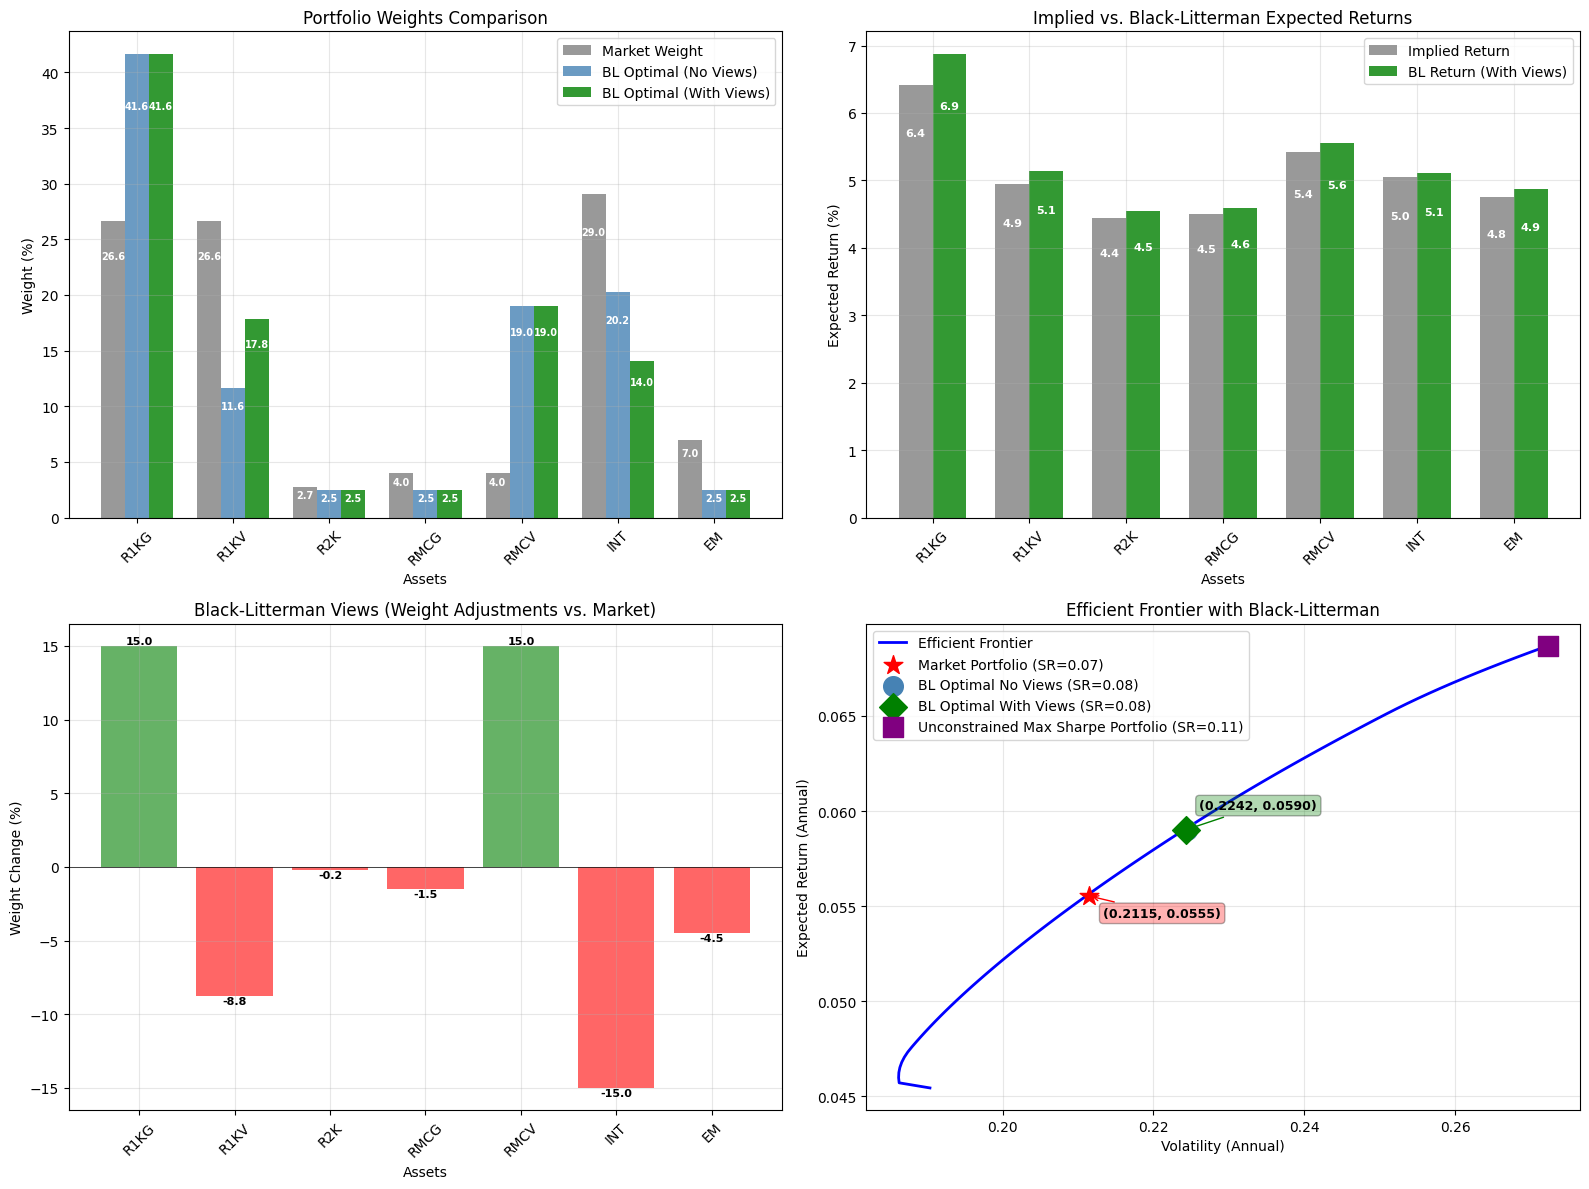

In [ ]:
# Step 6: Visualize Results
import matplotlib.pyplot as plt

# Calculate BL optimal weights without views for comparison
if len(views) > 0:
    # Optimize with no views (just use implied returns)
    if USE_MATCH_MARKET_VOL:
        objective_func_no_views = lambda x: -(x.T @ pi)
    else:
        objective_func_no_views = lambda x: neg_sharpe_ratio(x, pi, Sigma, risk_free_rate)
    
    result_no_views = minimize(
        objective_func_no_views,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9, 'maxiter': 1000}
    )
    optimal_weights_no_views = result_no_views.x
else:
    # If no views were used, the current optimal weights ARE the no-views weights
    optimal_weights_no_views = optimal_weights.copy()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Weight Comparison (3 groups)
ax1 = axes[0, 0]
x = np.arange(len(ticker_list))
width = 0.25
bars1 = ax1.bar(x - width, df_allocations['Market Weight (%)'], width, label='Market Weight', alpha=0.8, color='gray')
bars2 = ax1.bar(x, optimal_weights_no_views * 100, width, label='BL Optimal (No Views)', alpha=0.8, color='steelblue')
bars3 = ax1.bar(x + width, df_allocations['BL Optimal Weight (%)'], width, label='BL Optimal (With Views)', alpha=0.8, color='green')

# Annotate market weight bars
for i, (bar, val) in enumerate(zip(bars1, df_allocations['Market Weight (%)'])):
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height - height*0.1, f'{val:.1f}',
                 ha='center', va='top', fontsize=7, color='white', fontweight='bold')

# Annotate BL optimal no views bars
for i, (bar, val) in enumerate(zip(bars2, optimal_weights_no_views * 100)):
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height - height*0.1, f'{val:.1f}',
                 ha='center', va='top', fontsize=7, color='white', fontweight='bold')

# Annotate BL optimal with views bars
for i, (bar, val) in enumerate(zip(bars3, df_allocations['BL Optimal Weight (%)'])):
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height - height*0.1, f'{val:.1f}',
                 ha='center', va='top', fontsize=7, color='white', fontweight='bold')

ax1.set_xlabel('Assets')
ax1.set_ylabel('Weight (%)')
ax1.set_title('Portfolio Weights Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(ticker_list, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Return Comparison (2 groups)
ax2 = axes[0, 1]
width_returns = 0.35
bars4 = ax2.bar(x - width_returns/2, df_allocations['Implied Return (%)'], width_returns, label='Implied Return', alpha=0.8, color='gray')
bars5 = ax2.bar(x + width_returns/2, df_allocations['BL Expected Return (%)'], width_returns, label='BL Return (With Views)', alpha=0.8, color='green')

# Annotate implied return bars
for i, (bar, val) in enumerate(zip(bars4, df_allocations['Implied Return (%)'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height - height*0.1, f'{val:.1f}',
             ha='center', va='top', fontsize=8, color='white', fontweight='bold')

# Annotate BL return bars
for i, (bar, val) in enumerate(zip(bars5, df_allocations['BL Expected Return (%)'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height - height*0.1, f'{val:.1f}',
             ha='center', va='top', fontsize=8, color='white', fontweight='bold')

ax2.set_xlabel('Assets')
ax2.set_ylabel('Expected Return (%)')
ax2.set_title('Implied vs. Black-Litterman Expected Returns')
ax2.set_xticks(x)
ax2.set_xticklabels(ticker_list, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Weight Changes
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in df_allocations['Weight Change (%)']]
bars5 = ax3.bar(ticker_list, df_allocations['Weight Change (%)'], color=colors, alpha=0.6)

# Annotate weight change bars
for i, (bar, val) in enumerate(zip(bars5, df_allocations['Weight Change (%)'])):
    height = bar.get_height()
    # Position text based on positive or negative values
    if height >= 0:
        va = 'bottom'
        y_pos = height
    else:
        va = 'top'
        y_pos = height
    ax3.text(bar.get_x() + bar.get_width()/2., y_pos, f'{val:.1f}',
             ha='center', va=va, fontsize=8, fontweight='bold')

ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Assets')
ax3.set_ylabel('Weight Change (%)')
ax3.set_title('Black-Litterman Views (Weight Adjustments vs. Market)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Efficient Frontier
ax4 = axes[1, 1]

# Find maximum Sharpe ratio portfolio first (needed for frontier range)
bounds_max_sharpe = tuple((0, 1) for _ in range(len(BL_mean)))
constraints_max_sharpe = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
initial_guess_max_sharpe = np.array([1/len(BL_mean)] * len(BL_mean))

result_max_sharpe = minimize(
    lambda x: neg_sharpe_ratio(x, BL_mean, Sigma, risk_free_rate),
    initial_guess_max_sharpe,
    method='SLSQP',
    bounds=bounds_max_sharpe,
    constraints=constraints_max_sharpe,
    options={'ftol': 1e-9, 'maxiter': 1000}
)

max_sharpe_weights = result_max_sharpe.x
max_sharpe_return, max_sharpe_vol = portfolio_stats(max_sharpe_weights, BL_mean, Sigma)
max_sharpe_ratio = (max_sharpe_return - risk_free_rate) / max_sharpe_vol

# Generate efficient frontier with expanded range to include max Sharpe portfolio
n_portfolios = 100
min_return = min(BL_mean.min(), max_sharpe_return * 0.95)
max_return = max(BL_mean.max(), max_sharpe_return * 1.05)
target_returns = np.linspace(min_return, max_return, n_portfolios)
efficient_portfolios = []

# Use unconstrained bounds for efficient frontier (long-only)
bounds_ef = tuple((0, 1) for _ in range(len(BL_mean)))

for target in target_returns:
    constraints_ef = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x, target=target: x.T @ BL_mean - target}
    ]
    
    result_ef = minimize(
        lambda x: np.sqrt(x.T @ Sigma @ x),
        initial_guess_max_sharpe,
        method='SLSQP',
        bounds=bounds_ef,
        constraints=constraints_ef,
        options={'ftol': 1e-9, 'maxiter': 1000}
    )
    
    if result_ef.success:
        vol = np.sqrt(result_ef.x.T @ Sigma @ result_ef.x)
        efficient_portfolios.append((vol, target))

if efficient_portfolios:
    vols, rets = zip(*efficient_portfolios)
    ax4.plot(vols, rets, 'b-', linewidth=2, label='Efficient Frontier')

# Calculate stats for BL optimal portfolio with no views
return_no_views, vol_no_views = portfolio_stats(optimal_weights_no_views, BL_mean, Sigma)
sharpe_no_views = (return_no_views - risk_free_rate) / vol_no_views

# Plot portfolios
ax4.scatter(market_vol_bl, market_return_bl, s=200, c='red', marker='*', 
            label=f'Market Portfolio (SR={market_sharpe_bl:.2f})', zorder=5)
ax4.scatter(vol_no_views, return_no_views, s=200, c='steelblue', marker='o', 
            label=f'BL Optimal No Views (SR={sharpe_no_views:.2f})', zorder=5)
ax4.scatter(optimal_vol, optimal_return, s=200, c='green', marker='D', 
            label=f'BL Optimal With Views (SR={optimal_sharpe:.2f})', zorder=5)
ax4.scatter(max_sharpe_vol, max_sharpe_return, s=200, c='purple', marker='s', 
            label=f'Unconstrained Max Sharpe Portfolio (SR={max_sharpe_ratio:.2f})', zorder=5)

# Annotate market portfolio
ax4.annotate(f'({market_vol_bl:.4f}, {market_return_bl:.4f})',
             xy=(market_vol_bl, market_return_bl),
             xytext=(10, -15), textcoords='offset points',
             fontsize=9, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red'))

# Annotate BL optimal portfolio
ax4.annotate(f'({optimal_vol:.4f}, {optimal_return:.4f})',
             xy=(optimal_vol, optimal_return),
             xytext=(10, 15), textcoords='offset points',
             fontsize=9, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='green'))

ax4.set_xlabel('Volatility (Annual)')
ax4.set_ylabel('Expected Return (Annual)')
ax4.set_title('Efficient Frontier with Black-Litterman')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()


plt.savefig("./img/black_litterman.png", dpi=300)


# Risk Analytics

Comprehensive risk analysis of the optimal Black-Litterman portfolio including:
- **Risk Contribution**: Marginal and component risk by asset
- **Tracking Error**: Deviation from market portfolio
- **Downside Risk**: Semi-deviation and tail risk metrics
- **Concentration Risk**: Portfolio diversification measures

In [ ]:
# Risk Contribution Analysis

# 1. Marginal Contribution to Risk (MCR)
# MCR_i = (Σw)_i / σ_p
portfolio_vol_value = optimal_vol
mcr = (Sigma @ optimal_weights) / portfolio_vol_value

# 2. Component Contribution to Risk (CCR)
# CCR_i = w_i * MCR_i
ccr = optimal_weights * mcr

# 3. Percentage Contribution to Risk (PCR)
# PCR_i = CCR_i / σ_p
pcr = ccr / portfolio_vol_value

# 4. Tracking Error Components
active_weights = optimal_weights - w_mkt
tracking_variance = active_weights.T @ Sigma @ active_weights
tracking_error_value = np.sqrt(tracking_variance)

# Individual asset tracking error contributions
te_contributions = active_weights * (Sigma @ active_weights)
te_pct_contributions = te_contributions / tracking_variance

# 5. Risk-Adjusted Return Contribution
return_contributions = optimal_weights * BL_mean
risk_adj_contributions = return_contributions / ccr

df_risk_analysis = pd.DataFrame({
    'Ticker': ticker_list,
    'Weight (%)': optimal_weights * 100,
    'Marginal Risk': mcr,
    'Component Risk': ccr,
    'Risk Contribution (%)': pcr * 100,
    'Return Contribution (%)': (return_contributions / optimal_return) * 100,
    'Risk/Return Ratio': ccr / return_contributions,
    'Active Weight (%)': active_weights * 100,
    'TE Contribution (%)': te_pct_contributions * 100
})

print("Risk Contribution Analysis:")
print("="*120)
print(f"Portfolio Volatility: {portfolio_vol_value:.4f}")
print(f"Tracking Error vs Market: {tracking_error_value:.4f}")
print(f"Information Ratio: {(optimal_return - market_return_bl) / tracking_error_value:.4f}")
print("="*120)
display(df_risk_analysis.round(4))

# Verify risk contributions sum to portfolio volatility
print(f"\nVerification: Sum of Component Risks = {ccr.sum():.6f} (should equal portfolio vol = {portfolio_vol_value:.6f})")
print(f"Verification: Sum of Risk Contributions = {pcr.sum() * 100:.2f}% (should equal 100%)")

Risk Contribution Analysis:
Portfolio Volatility: 0.2242
Tracking Error vs Market: 0.0256
Information Ratio: 0.1355


,Ticker,Weight (%),Marginal Risk,Component Risk,Risk Contribution (%),Return Contribution (%),Risk/Return Ratio,Active Weight (%),TE Contribution (%)
0,R1KG,41.6151,0.2606,0.1085,48.3635,48.4354,3.7948,15.0000,107.4630
1,R1KV,17.8294,0.1930,0.0344,15.3487,15.5490,3.7514,-8.7856,-25.0838
2,R2K,2.5000,0.1735,0.0043,1.9342,1.9254,3.8176,-0.2234,-0.5682
3,RMCG,2.5000,0.1730,0.0043,1.9289,1.9427,3.7735,-1.5232,-2.5739
4,RMCV,19.0232,0.2145,0.0408,18.1976,17.9235,3.8585,15.0000,62.3371
5,INT,14.0323,0.1943,0.0273,12.1592,12.1594,3.8003,-15.0000,-29.3480
6,EM,2.5000,0.1855,0.0046,2.0680,2.0645,3.8067,-4.4677,-12.2262



Verification: Sum of Component Risks = 0.224247 (should equal portfolio vol = 0.224247)
Verification: Sum of Risk Contributions = 100.00% (should equal 100%)


In [ ]:
# Downside Risk Analysis

# Calculate portfolio returns based on historical data
optimal_portfolio_returns = returns @ optimal_weights
market_portfolio_returns = returns @ w_mkt

# 1. Semi-deviation (downside volatility)
# Only consider returns below the mean
optimal_mean_return = optimal_portfolio_returns.mean()
market_mean_return = market_portfolio_returns.mean()

downside_optimal = optimal_portfolio_returns[optimal_portfolio_returns < optimal_mean_return]
downside_market = market_portfolio_returns[market_portfolio_returns < market_mean_return]

semi_deviation_optimal = downside_optimal.std() * np.sqrt(252)
semi_deviation_market = downside_market.std() * np.sqrt(252)

# 2. Sortino Ratio
sortino_optimal = (optimal_return - risk_free_rate) / semi_deviation_optimal
sortino_market = (market_return_bl - risk_free_rate) / semi_deviation_market

# 3. Value at Risk (VaR) - 95% and 99% confidence
var_95_optimal = optimal_portfolio_returns.quantile(0.05) * np.sqrt(252)
var_99_optimal = optimal_portfolio_returns.quantile(0.01) * np.sqrt(252)
var_95_market = market_portfolio_returns.quantile(0.05) * np.sqrt(252)
var_99_market = market_portfolio_returns.quantile(0.01) * np.sqrt(252)

# 4. Conditional Value at Risk (CVaR / Expected Shortfall)
cvar_95_optimal = optimal_portfolio_returns[optimal_portfolio_returns <= optimal_portfolio_returns.quantile(0.05)].mean() * np.sqrt(252)
cvar_99_optimal = optimal_portfolio_returns[optimal_portfolio_returns <= optimal_portfolio_returns.quantile(0.01)].mean() * np.sqrt(252)
cvar_95_market = market_portfolio_returns[market_portfolio_returns <= market_portfolio_returns.quantile(0.05)].mean() * np.sqrt(252)
cvar_99_market = market_portfolio_returns[market_portfolio_returns <= market_portfolio_returns.quantile(0.01)].mean() * np.sqrt(252)

# 5. Maximum Drawdown
def calculate_max_drawdown(returns_series):
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

max_dd_optimal = calculate_max_drawdown(optimal_portfolio_returns)
max_dd_market = calculate_max_drawdown(market_portfolio_returns)

# 6. Downside Capture Ratio (vs market)
# How much does the portfolio capture on market down days?
market_down_days = market_portfolio_returns < 0
if market_down_days.sum() > 0:
    downside_capture = (optimal_portfolio_returns[market_down_days].mean() / 
                       market_portfolio_returns[market_down_days].mean())
else:
    downside_capture = np.nan

df_downside_risk = pd.DataFrame({
    'Metric': [
        'Semi-Deviation (Annual)',
        'Sortino Ratio',
        'VaR 95% (Annual)',
        'VaR 99% (Annual)',
        'CVaR 95% (Annual)',
        'CVaR 99% (Annual)',
        'Maximum Drawdown',
        'Downside Capture Ratio'
    ],
    'BL Optimal Portfolio': [
        semi_deviation_optimal,
        sortino_optimal,
        var_95_optimal,
        var_99_optimal,
        cvar_95_optimal,
        cvar_99_optimal,
        max_dd_optimal,
        downside_capture
    ],
    'Market Portfolio': [
        semi_deviation_market,
        sortino_market,
        var_95_market,
        var_99_market,
        cvar_95_market,
        cvar_99_market,
        max_dd_market,
        1.0  # Market vs itself
    ]
})

df_downside_risk['Difference'] = df_downside_risk['BL Optimal Portfolio'] - df_downside_risk['Market Portfolio']

print("Downside Risk Analysis:")
print("="*100)
display(df_downside_risk.round(4))
print("\nInterpretation:")
print("- Lower semi-deviation = less downside volatility")
print("- Higher Sortino ratio = better risk-adjusted returns considering only downside risk")
print("- VaR/CVaR = potential losses at different confidence levels")
print("- Lower maximum drawdown = smaller peak-to-trough decline")
print("- Downside capture < 1.0 = portfolio declines less than market on down days")

Downside Risk Analysis:


,Metric,BL Optimal Portfolio,Market Portfolio,Difference
0,Semi-Deviation (Annual),0.1799,0.1721,0.0078
1,Sortino Ratio,0.1057,0.0903,0.0154
2,VaR 95% (Annual),-0.3211,-0.3040,-0.0172
3,VaR 99% (Annual),-0.6319,-0.6149,-0.0170
4,CVaR 95% (Annual),-0.5390,-0.5123,-0.0267
5,CVaR 99% (Annual),-0.9806,-0.9326,-0.0480
6,Maximum Drawdown,-0.6606,-0.6481,-0.0124
7,Downside Capture Ratio,1.0632,1.0000,0.0632



Interpretation:
- Lower semi-deviation = less downside volatility
- Higher Sortino ratio = better risk-adjusted returns considering only downside risk
- VaR/CVaR = potential losses at different confidence levels
- Lower maximum drawdown = smaller peak-to-trough decline
- Downside capture < 1.0 = portfolio declines less than market on down days


In [ ]:
# Concentration Risk Analysis

# 1. Herfindahl-Hirschman Index (HHI)
# Measures concentration: 0 = perfectly diversified, 1 = fully concentrated
hhi_optimal = np.sum(optimal_weights ** 2)
hhi_market = np.sum(w_mkt ** 2)

# 2. Effective Number of Assets
# How many equally-weighted assets would produce the same diversification
n_effective_optimal = 1 / hhi_optimal
n_effective_market = 1 / hhi_market

# 3. Gini Coefficient
# Measures inequality of weight distribution: 0 = perfect equality, 1 = maximum inequality
def gini_coefficient(weights):
    sorted_weights = np.sort(weights)
    n = len(weights)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * sorted_weights)) / (n * np.sum(sorted_weights)) - (n + 1) / n

gini_optimal = gini_coefficient(optimal_weights)
gini_market = gini_coefficient(w_mkt)

# 4. Diversification Ratio
# Ratio of weighted average volatility to portfolio volatility
individual_vols = np.sqrt(np.diag(Sigma))
weighted_avg_vol_optimal = np.sum(optimal_weights * individual_vols)
weighted_avg_vol_market = np.sum(w_mkt * individual_vols)

div_ratio_optimal = weighted_avg_vol_optimal / portfolio_vol_value
div_ratio_market = weighted_avg_vol_market / market_vol_bl

# 5. Maximum Weight
max_weight_optimal = optimal_weights.max()
max_weight_market = w_mkt.max()

# 6. Top 3 Concentration
top3_pct_optimal = np.sort(optimal_weights)[-3:].sum()
top3_pct_market = np.sort(w_mkt)[-3:].sum()

df_concentration = pd.DataFrame({
    'Metric': [
        'Herfindahl-Hirschman Index',
        'Effective Number of Assets',
        'Gini Coefficient',
        'Diversification Ratio',
        'Maximum Single Weight',
        'Top 3 Assets Concentration',
        'Number of Assets'
    ],
    'BL Optimal Portfolio': [
        hhi_optimal,
        n_effective_optimal,
        gini_optimal,
        div_ratio_optimal,
        max_weight_optimal,
        top3_pct_optimal,
        len(optimal_weights)
    ],
    'Market Portfolio': [
        hhi_market,
        n_effective_market,
        gini_market,
        div_ratio_market,
        max_weight_market,
        top3_pct_market,
        len(w_mkt)
    ]
})

df_concentration['Difference'] = df_concentration['BL Optimal Portfolio'] - df_concentration['Market Portfolio']

print("Concentration Risk Analysis:")
print("="*100)
display(df_concentration.round(4))
print("\nInterpretation:")
print("- Lower HHI = more diversified portfolio")
print("- Higher effective N = more evenly distributed weights")
print("- Lower Gini = more equal weight distribution")
print("- Higher diversification ratio = better diversification benefits")
print("- Lower top 3 concentration = less reliance on few positions")

Concentration Risk Analysis:


,Metric,BL Optimal Portfolio,Market Portfolio,Difference
0,Herfindahl-Hirschman Index,0.2627,0.2348,0.0279
1,Effective Number of Assets,3.8063,4.2591,-0.4528
2,Gini Coefficient,0.4735,0.4191,0.0543
3,Diversification Ratio,1.0721,1.0713,0.0008
4,Maximum Single Weight,0.4162,0.2903,0.1258
5,Top 3 Assets Concentration,0.7847,0.8226,-0.0379
6,Number of Assets,7.0000,7.0000,0.0000



Interpretation:
- Lower HHI = more diversified portfolio
- Higher effective N = more evenly distributed weights
- Lower Gini = more equal weight distribution
- Higher diversification ratio = better diversification benefits
- Lower top 3 concentration = less reliance on few positions


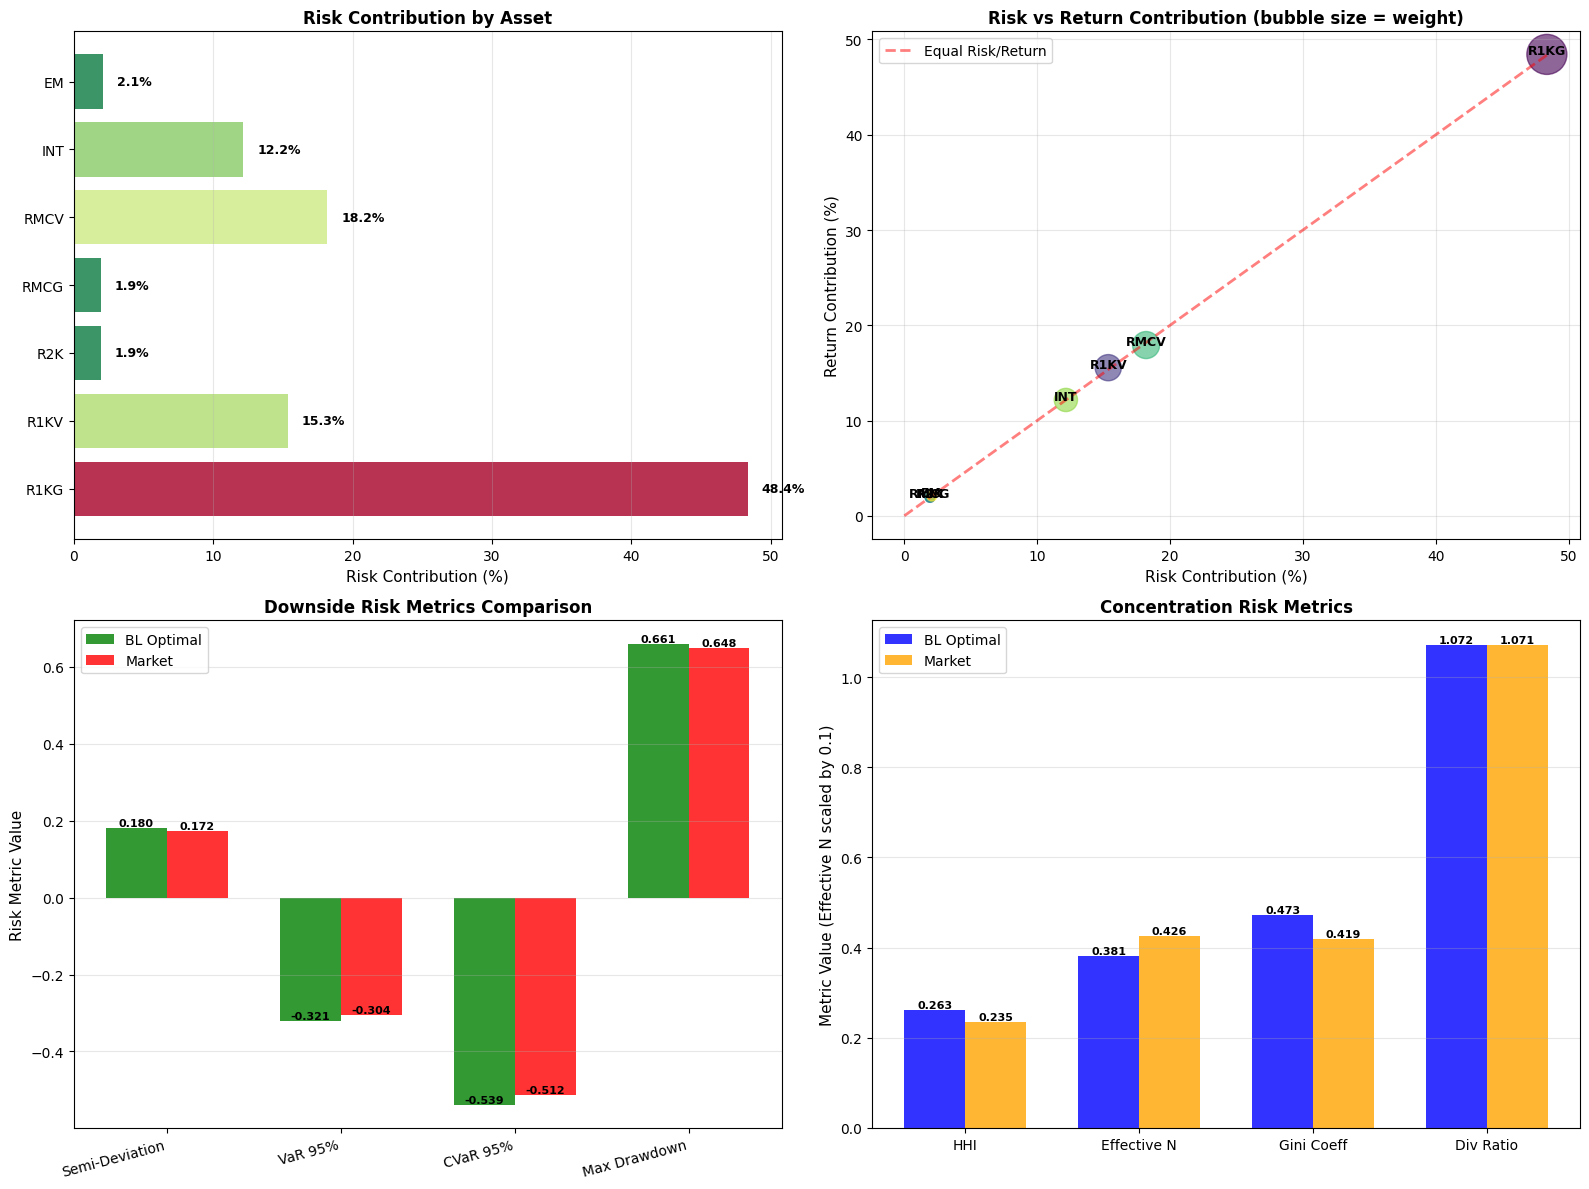

In [ ]:
# Visualize Risk Analytics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk Contribution Breakdown
ax1 = axes[0, 0]
x_pos = np.arange(len(ticker_list))
colors_risk = plt.cm.RdYlGn_r(pcr / pcr.max())
bars = ax1.barh(x_pos, pcr * 100, color=colors_risk, alpha=0.8)
ax1.set_yticks(x_pos)
ax1.set_yticklabels(ticker_list)
ax1.set_xlabel('Risk Contribution (%)', fontsize=11)
ax1.set_title('Risk Contribution by Asset', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, pcr * 100)):
    ax1.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%',
             va='center', fontsize=9, fontweight='bold')

# 2. Risk vs Return Contribution
ax2 = axes[0, 1]
risk_contrib = pcr * 100
return_contrib = (return_contributions / optimal_return) * 100
scatter = ax2.scatter(risk_contrib, return_contrib, s=optimal_weights*2000, 
                     alpha=0.6, c=range(len(ticker_list)), cmap='viridis')
ax2.plot([0, max(risk_contrib.max(), return_contrib.max())], 
         [0, max(risk_contrib.max(), return_contrib.max())], 
         'r--', linewidth=2, alpha=0.5, label='Equal Risk/Return')
for i, ticker in enumerate(ticker_list):
    ax2.annotate(ticker, (risk_contrib[i], return_contrib[i]), 
                fontsize=9, fontweight='bold', ha='center')
ax2.set_xlabel('Risk Contribution (%)', fontsize=11)
ax2.set_ylabel('Return Contribution (%)', fontsize=11)
ax2.set_title('Risk vs Return Contribution (bubble size = weight)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Downside Risk Comparison
ax3 = axes[1, 0]
downside_metrics = ['Semi-Deviation', 'VaR 95%', 'CVaR 95%', 'Max Drawdown']
downside_optimal_vals = [semi_deviation_optimal, var_95_optimal, cvar_95_optimal, abs(max_dd_optimal)]
downside_market_vals = [semi_deviation_market, var_95_market, cvar_95_market, abs(max_dd_market)]

x_metrics = np.arange(len(downside_metrics))
width = 0.35
bars1 = ax3.bar(x_metrics - width/2, downside_optimal_vals, width, label='BL Optimal', alpha=0.8, color='green')
bars2 = ax3.bar(x_metrics + width/2, downside_market_vals, width, label='Market', alpha=0.8, color='red')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

ax3.set_ylabel('Risk Metric Value', fontsize=11)
ax3.set_title('Downside Risk Metrics Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x_metrics)
ax3.set_xticklabels(downside_metrics, rotation=15, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Concentration Metrics Comparison
ax4 = axes[1, 1]
concentration_metrics = ['HHI', 'Effective N', 'Gini Coeff', 'Div Ratio']
concentration_optimal_vals = [hhi_optimal, n_effective_optimal/10, gini_optimal, div_ratio_optimal]
concentration_market_vals = [hhi_market, n_effective_market/10, gini_market, div_ratio_market]

x_conc = np.arange(len(concentration_metrics))
bars3 = ax4.bar(x_conc - width/2, concentration_optimal_vals, width, label='BL Optimal', alpha=0.8, color='blue')
bars4 = ax4.bar(x_conc + width/2, concentration_market_vals, width, label='Market', alpha=0.8, color='orange')

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

ax4.set_ylabel('Metric Value (Effective N scaled by 0.1)', fontsize=11)
ax4.set_title('Concentration Risk Metrics', fontsize=12, fontweight='bold')
ax4.set_xticks(x_conc)
ax4.set_xticklabels(concentration_metrics)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("./img/risk_analytics.png", dpi=300)
plt.show()